# About the project

Photo sharing and photo storage services like to have location data for each photo that is uploaded. With the location data, these services can build advanced features, such as automatic suggestion of relevant tags or automatic photo organization, which help provide a compelling user experience. Although a photo's location can often be obtained by looking at the photo's metadata, many photos uploaded to these services will not have location metadata available. This can happen when, for example, the camera capturing the picture does not have GPS or if a photo's metadata is scrubbed due to privacy concerns.

If no location metadata for an image is available, one way to infer the location is to detect and classify a discernable landmark in the image. Given the large number of landmarks across the world and the immense volume of images that are uploaded to photo sharing services, using human judgement to classify these landmarks would not be feasible.

In this notebook, we will take the first steps towards addressing this problem by building models to automatically predict the location of the image based on any landmarks depicted in the image.



### The Road Ahead

We break the notebook into separate steps.  Feel free to use the links below to navigate the notebook.

* [Step 0](#step0): Download Datasets and Install Python Modules
* [Step 1](#step1): Create a CNN to Classify Landmarks (from Scratch)
* [Step 2](#step2): Create a CNN to Classify Landmarks (using Transfer Learning)
* [Step 3](#step3): Write Our Landmark Prediction Algorithm

---
<a id='step0'></a>
## Step 0: Install Python Modules


Install the following Python modules:
* seaborn
* matplotlib
* numpy
* PIL
* torch
* torchvision

---

<a id='step1'></a>
## Step 1: Create a CNN to Classify Landmarks (from Scratch)

In this step, we will create a CNN that classifies landmarks. We aim an accuracy above 20%.

Although 20% may seem low at first glance, it seems more reasonable after realizing how difficult of a problem this is. Many times, an image that is taken at a landmark captures a fairly mundane image of an animal or plant, like in the following picture.

<img src="images/train/00.Haleakala_National_Park/084c2aa50d0a9249.jpg" alt="Bird in Haleakalā National Park" style="width: 400px;"/>

Just by looking at that image alone, would you have been able to guess that it was taken at the Haleakalā National Park in Hawaii?

An accuracy of 20% is significantly better than random guessing, which would provide an accuracy of just 2%. In Step 2 of this notebook, we will improve accuracy by using transfer learning to create a CNN.

### Specify Data Loaders for the Landmark Dataset

Dataset can be found at `/data/landmark_images/` in the workspace.

In [1]:
# Install splitfolders to split train data into train and valid
!pip install split-folders

In [2]:
import splitfolders
# Split train data to train and valid 
splitfolders.ratio("/data/landmark_images/train", output="train_valid", seed=1337, ratio=(.8, .2), group_prefix=None)

Copying files: 4996 files [00:01, 2715.16 files/s]


In [3]:
import os
def fn():       # 1.Get file names from directory
    file_list=os.listdir(r"train_valid")
    print (file_list)

fn()

['train', 'val']


In [4]:
import torch
from torchvision import transforms, datasets, models
from torch.utils.data.sampler import SubsetRandomSampler
import numpy as np



loaders_scratch = {'train': None, 'valid': None, 'test': None}

# Batch size and number of workers
batch_size = 64
num_workers = 0

# Define transformers
transform_train = transforms.Compose([transforms.Resize(260), 
                                      transforms.CenterCrop(256),
                                      transforms.RandomHorizontalFlip(), 
                                      transforms.RandomRotation(20),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.5, 0.5, 0.5], 
                                                             [0.5, 0.5, 0.5])
                               ])

transform_test_valid = transforms.Compose([transforms.Resize(260), 
                                     transforms.CenterCrop(256),
                                     transforms.ToTensor(),
                                     transforms.Normalize([0.5, 0.5, 0.5],
                                                          [0.5, 0.5, 0.5])])

# Get the data
train_data = datasets.ImageFolder("train_valid/train", transform= transform_train)
valid_data = datasets.ImageFolder("train_valid/val", transform = transform_test_valid)
test_data = datasets.ImageFolder("/data/landmark_images/test", transform = transform_test_valid)


# Get data loaders
loaders_scratch["train"] = torch.utils.data.DataLoader(train_data, 
                                           batch_size = batch_size,
                                           num_workers = num_workers,
                                           shuffle = True)

loaders_scratch["valid"] = torch.utils.data.DataLoader(valid_data, 
                                           batch_size = batch_size,
                                           num_workers = num_workers)

loaders_scratch["test"] = torch.utils.data.DataLoader(test_data, 
                                                      batch_size = batch_size,
                                                      num_workers = num_workers)

In [5]:
classes = [label[3:] for label in train_data.classes]
classes

['Haleakala_National_Park',
 'Mount_Rainier_National_Park',
 'Ljubljana_Castle',
 'Dead_Sea',
 'Wroclaws_Dwarves',
 'London_Olympic_Stadium',
 'Niagara_Falls',
 'Stonehenge',
 'Grand_Canyon',
 'Golden_Gate_Bridge',
 'Edinburgh_Castle',
 'Mount_Rushmore_National_Memorial',
 'Kantanagar_Temple',
 'Yellowstone_National_Park',
 'Terminal_Tower',
 'Central_Park',
 'Eiffel_Tower',
 'Changdeokgung',
 'Delicate_Arch',
 'Vienna_City_Hall',
 'Matterhorn',
 'Taj_Mahal',
 'Moscow_Raceway',
 'Externsteine',
 'Soreq_Cave',
 'Banff_National_Park',
 'Pont_du_Gard',
 'Seattle_Japanese_Garden',
 'Sydney_Harbour_Bridge',
 'Petronas_Towers',
 'Brooklyn_Bridge',
 'Washington_Monument',
 'Hanging_Temple',
 'Sydney_Opera_House',
 'Great_Barrier_Reef',
 'Monumento_a_la_Revolucion',
 'Badlands_National_Park',
 'Atomium',
 'Forth_Bridge',
 'Gateway_of_India',
 'Stockholm_City_Hall',
 'Machu_Picchu',
 'Death_Valley_National_Park',
 'Gullfoss_Falls',
 'Trevi_Fountain',
 'Temple_of_Heaven',
 'Great_Wall_of_China',

**Description**: 
- I decided to first resize and then crop the center of image. I thought 256 would be a reasonable size. Since It's not an easy task, I thought the resolution might matter, on the other hand, I didn't want it to take too long to train because I wanted to experiment with different architectures. So, all in all, I decided on 256 based on these thoughts and the fact that it's a power of two, and it would be easy to use max-pooling for reducing dimensionality and losing less information.



- I decided to augment data with random horizontal flip and rotation of 20 degrees. I chose these transforms because I wanted the model to have a better understanding of what it might see in the wild. People usually rotate photos with small degrees or flip them horizontally (more than vertically) when posting them on social media or in general, so I thought it would be good to reflect these transforms in our data.

### Visualize a Batch of Training Data

Visualizing the output of our data loader to ensure that our data loading and preprocessing are working as expected.

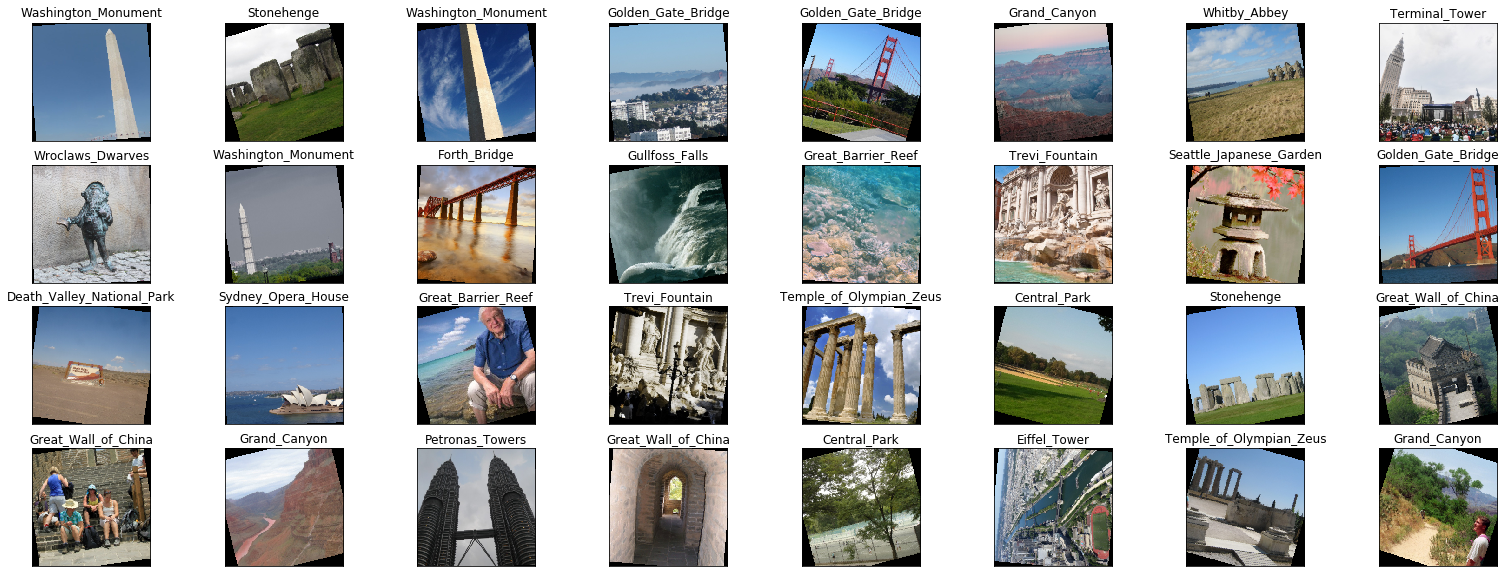

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# visualize a batch of the train data loader


dataiter = iter(loaders_scratch["train"])

images, labels = dataiter.next()
images = images.numpy().transpose(0, 2, 3, 1) * 0.5 + 0.5

fig = plt.figure(figsize = (27, 10))

for i in range(min(len(images), 32)):
    ax = fig.add_subplot(4, min(len(images), 32)/4, i+1, xticks = [], yticks=[])
    ax.imshow(images[i])
    ax.set_title(classes[labels[i]])

### Initialize use_cuda variable

In [7]:
# useful variable that tells us whether we should use the GPU
use_cuda = torch.cuda.is_available()

Specify Loss Function and Optimizer

In [8]:
## select loss function
criterion_scratch = torch.nn.CrossEntropyLoss()

def get_optimizer_scratch(model):
    ##  select and return an optimizer
    return torch.optim.SGD(model.parameters(), lr = 0.1)
    
    

###  Model Architecture

Create a CNN to classify images of landmarks.

In [9]:
import torch.nn as nn
import torch.nn.functional as F

# define the CNN architecture
class Net(nn.Module):
    ## choose an architecture, and complete the class
    def __init__(self):
        super(Net, self).__init__()
        
        ## Define layers of a CNN
        self.conv1 = nn.Conv2d(3, 16, 3, padding = 1)
        self.conv2 = nn.Conv2d(16, 64, 3, padding = 1)
        self.conv3 = nn.Conv2d(64, 256, 3, padding = 1)
        
        self.pool = nn.MaxPool2d(2, 2)
        
        self.fc1 = nn.Linear(256 * 32 * 32, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 50)
        
        self.dropout = nn.Dropout(0.2)

        
        
    
    def forward(self, x):
        ## Define forward behavior
        
        x = F.relu(self.conv1(x)) # 16 256 256
        x = self.pool(x) # 16 128 128
        
        x = F.relu(self.conv2(x)) # 64 128 128
        x = self.pool(x) # 64 64 64
        
        x = F.relu(self.conv3(x)) # 256 64 64
        x = self.pool(x) # 256 32 32
        
        
        # Flatten
        x = x.view(x.shape[0], -1)
        
        # Fully-connected
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = F.dropout(x)
        x = self.fc3(x)    
        
        return x


# instantiate the CNN
model_scratch = Net()

# move tensors to GPU if CUDA is available
if use_cuda:
    model_scratch.cuda()

__Description:__  

- I thought about the number of convolutional layers I wanted. I decided to have at least ten layers since there are fifty classes, and a simple model with less complexity might underfit.



- Then I estimated the number of parameters for ten layers and decided to cut it down to eight layers to get less complixity and have a faster training 



- After that, I tried to design an architecture based on number of layers, so I took a pen and paper and started thinking. I tried to get inspiration by looking at VGG architecture (since it's not a very complex model and based on the number of chosen convolutional layers, mine wasn't too complex too)




- I decided to have blocks of convolutions followed by a max-pooling layer similar to the first layers of VGG but simpler. I have two stacks of one convolutional layer followed by three stacks of two convolutional layers. There is a max-pooling layer after each stack




- I decided on the number of kernels of each layer based on two goals: 
>1. increasing the depth as we go deeper 
>2. Keep the parameters as low as possible



- I wasn't sure to add dropout layers since the task is too complex for this model to overfit, but in the end, I decided to err on the side of caution and use them.

- After trying that, I realized that the model didn't give me the expected result; hence, I reduced the number of layers, so I gradually reduced the number of layers and blocks, and finally, I decided on the current architecture.

- My final architecture turned out to be much less that the first one! Only three conv layers.

### Implement the Training Algorithm


In [10]:
def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    
    # add learning-rate scheduler 
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode = "min", factor= 0.5, patience=4)
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        # set the module to training mode
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()

            optimizer.zero_grad()
            
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            
            optimizer.step()
            
            # sequential estimation
            ## record the average training loss, using
            ## train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data.item() - train_loss))
            train_loss += (1/(batch_idx+1)) * (loss.item() - train_loss)
               

        ######################    
        # validate the model #
        ######################
        # set the model to evaluation mode
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()

            # update average validation loss 
            output = model(data)

            loss = criterion(output, target)

            valid_loss += (1/(batch_idx+1))*(loss.item()-valid_loss)


        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))

        scheduler.step(valid_loss)

        ## if the validation loss has decreased, save the model at the filepath stored in save_path
        if valid_loss_min>valid_loss:
            torch.save(model.state_dict(), save_path)
            valid_loss_min = valid_loss
        
    return model

### Experiment with the Weight Initialization

Defining a custom weight initialization, and then train with our weight initialization for a few epochs:


In [11]:
def custom_weight_init(m):
    classname = m.__class__.__name__
    
    if classname.find("Linear") != -1:
        m.weight.data.normal_(0, m.in_features**-0.5)
        m.bias.data.fill_(0)
    
    
    
model_scratch.apply(custom_weight_init)
model_scratch = train(20, loaders_scratch, model_scratch, get_optimizer_scratch(model_scratch),
                      criterion_scratch, use_cuda, 'ignore.pt')

Epoch: 1 	Training Loss: 3.911926 	Validation Loss: 3.882234
Epoch: 2 	Training Loss: 3.838284 	Validation Loss: 3.794275
Epoch: 3 	Training Loss: 3.735505 	Validation Loss: 3.712814
Epoch: 4 	Training Loss: 3.711018 	Validation Loss: 3.717190
Epoch: 5 	Training Loss: 3.629102 	Validation Loss: 3.677263
Epoch: 6 	Training Loss: 3.496712 	Validation Loss: 3.568228
Epoch: 7 	Training Loss: 3.421312 	Validation Loss: 3.425683
Epoch: 8 	Training Loss: 3.349370 	Validation Loss: 3.533705
Epoch: 9 	Training Loss: 3.292259 	Validation Loss: 3.417229
Epoch: 10 	Training Loss: 3.248380 	Validation Loss: 3.354475
Epoch: 11 	Training Loss: 3.175211 	Validation Loss: 3.407957
Epoch: 12 	Training Loss: 3.079554 	Validation Loss: 3.238326
Epoch: 13 	Training Loss: 3.011615 	Validation Loss: 3.358637
Epoch: 14 	Training Loss: 2.956060 	Validation Loss: 3.479031
Epoch: 15 	Training Loss: 2.872262 	Validation Loss: 3.255072
Epoch: 16 	Training Loss: 2.827678 	Validation Loss: 3.667200
Epoch: 17 	Traini

### Train and Validate the Model

In [12]:
num_epochs = 30


# function to re-initialize a model with pytorch's default weight initialization
def default_weight_init(m):
    reset_parameters = getattr(m, 'reset_parameters', None)
    if callable(reset_parameters):
        m.reset_parameters()

# reset the model parameters
model_scratch.apply(default_weight_init)

# train the model
model_scratch = train(num_epochs, loaders_scratch, model_scratch, get_optimizer_scratch(model_scratch), 
                      criterion_scratch, use_cuda, 'model_scratch.pt')

Epoch: 1 	Training Loss: 3.913697 	Validation Loss: 3.906247
Epoch: 2 	Training Loss: 3.872648 	Validation Loss: 3.815277
Epoch: 3 	Training Loss: 3.777726 	Validation Loss: 3.716372
Epoch: 4 	Training Loss: 3.705059 	Validation Loss: 3.812633
Epoch: 5 	Training Loss: 3.654497 	Validation Loss: 3.892538
Epoch: 6 	Training Loss: 3.603996 	Validation Loss: 3.618081
Epoch: 7 	Training Loss: 3.514434 	Validation Loss: 3.521307
Epoch: 8 	Training Loss: 3.471663 	Validation Loss: 3.551869
Epoch: 9 	Training Loss: 3.409467 	Validation Loss: 3.552058
Epoch: 10 	Training Loss: 3.438368 	Validation Loss: 3.632614
Epoch: 11 	Training Loss: 3.347098 	Validation Loss: 3.359937
Epoch: 12 	Training Loss: 3.266035 	Validation Loss: 3.697730
Epoch: 13 	Training Loss: 3.233286 	Validation Loss: 3.372230
Epoch: 14 	Training Loss: 3.152247 	Validation Loss: 3.275218
Epoch: 15 	Training Loss: 3.095867 	Validation Loss: 3.199760
Epoch: 16 	Training Loss: 3.060559 	Validation Loss: 3.136576
Epoch: 17 	Traini

### Test the Model

In [13]:
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    # set the module to evaluation mode
    model.eval()
    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data.item() - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)

    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

# load the model that got the best validation accuracy
model_scratch.load_state_dict(torch.load('model_scratch.pt'))
test(loaders_scratch, model_scratch, criterion_scratch, use_cuda)

Test Loss: 2.791638


Test Accuracy: 32% (400/1250)


As you can see, we reached an accuracy of 32% which is way better than expected.

---
<a id='step2'></a>
## Step 2: Create a CNN to Classify Landmarks (using Transfer Learning)

We will now use transfer learning to create a CNN that can identify landmarks from images. Our aim is an accuracy of at least 60%

### Specify Data Loaders for the Landmark Dataset

In [29]:
loaders_transfer = {'train': None, 'valid': None, 'test': None}

# Batch size and number of workers
batch_size = 128
num_workers = 0

# Define transformers
transform_train = transforms.Compose([transforms.Resize(260), 
                                      transforms.CenterCrop(256),
                                      transforms.RandomHorizontalFlip(), 
                                      transforms.RandomRotation(20),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406], 
                                                           [0.229, 0.224, 0.225])
                               ])

transform_test_valid = transforms.Compose([transforms.Resize(260), 
                                     transforms.CenterCrop(256),
                                     transforms.ToTensor(),
                                     transforms.Normalize([0.485, 0.456, 0.406],
                                                          [0.229, 0.224, 0.225])])

# Get the data
train_data = datasets.ImageFolder("train_valid/train", transform= transform_train)
valid_data = datasets.ImageFolder("train_valid/val", transform = transform_test_valid)
test_data = datasets.ImageFolder("/data/landmark_images/test", transform = transform_test_valid)


# Get data loaders
loaders_transfer["train"] = torch.utils.data.DataLoader(train_data, 
                                           batch_size = batch_size,
                                           num_workers = num_workers,
                                           shuffle = True)

loaders_transfer["valid"] = torch.utils.data.DataLoader(valid_data, 
                                           batch_size = batch_size,
                                           num_workers = num_workers)

loaders_transfer["test"] = torch.utils.data.DataLoader(test_data, 
                                                      batch_size = batch_size,
                                                      num_workers = num_workers)






### Specify Loss Function and Optimizer


In [30]:
## select loss function
criterion_transfer = torch.nn.CrossEntropyLoss()


def get_optimizer_transfer(model):
    ##  select and return optimizer
    return torch.optim.SGD(model.fc.parameters(), lr = 0.1)
    
    

### Model Architecture

I decided on resnet50 based on three observations:

1. I read so many papers that used it and got excellent results
2. I used it before for my university projects
3. It had just the correct number of layers for me, deep but not very

In [31]:
## Specify model architecture

model_transfer = models.resnet50(pretrained = True)

for param in model_transfer.parameters():
    param.requires_grad = False

model_transfer.fc = nn.Linear(8192, 50)

use_cuda = torch.cuda.is_available()


if use_cuda:
    model_transfer = model_transfer.cuda()

In [32]:
model_transfer

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=F

### Train and Validate the Model


In [33]:
# train the model and save the best model parameters at filepath 'model_transfer.pt'
epochs = 30

model_transfer = train(epochs, loaders_transfer, model_transfer, get_optimizer_transfer(model_transfer), 
                      criterion_transfer, use_cuda, 'model_transfer.pt')



# load the model that got the best validation accuracy
model_transfer.load_state_dict(torch.load('model_transfer.pt'))

Epoch: 1 	Training Loss: 23.351240 	Validation Loss: 20.991266
Epoch: 2 	Training Loss: 9.203518 	Validation Loss: 9.130671
Epoch: 3 	Training Loss: 4.238294 	Validation Loss: 5.427385
Epoch: 4 	Training Loss: 2.947646 	Validation Loss: 7.978762
Epoch: 5 	Training Loss: 3.686464 	Validation Loss: 4.537788
Epoch: 6 	Training Loss: 1.961036 	Validation Loss: 3.120272
Epoch: 7 	Training Loss: 1.557566 	Validation Loss: 3.574106
Epoch: 8 	Training Loss: 1.220592 	Validation Loss: 3.655297
Epoch: 9 	Training Loss: 1.411437 	Validation Loss: 3.326867
Epoch: 10 	Training Loss: 1.352425 	Validation Loss: 4.799143
Epoch: 11 	Training Loss: 1.289790 	Validation Loss: 2.538442
Epoch: 12 	Training Loss: 0.867120 	Validation Loss: 2.904740
Epoch: 13 	Training Loss: 0.896688 	Validation Loss: 2.431625
Epoch: 14 	Training Loss: 0.893436 	Validation Loss: 2.818418
Epoch: 15 	Training Loss: 0.856793 	Validation Loss: 2.795385
Epoch: 16 	Training Loss: 0.713649 	Validation Loss: 2.399998
Epoch: 17 	Trai

###  Test the Model


In [34]:
test(loaders_transfer, model_transfer, criterion_transfer, use_cuda)

Test Loss: 1.323564


Test Accuracy: 73% (918/1250)


As you can see, we reached an accuracy of 73% which is way better than expected.

---
<a id='step3'></a>
## Step 3: Write Our Landmark Prediction Algorithm

Defining some functions to make it easy for others to use your classifiers.

###   Part 1

Implementing the function `predict_landmarks`, which accepts a file path to an image and an integer k, and then predicts the **top k most likely landmarks**. 



In [77]:
import seaborn as sns
from PIL import Image

device = "cuda" if torch.cuda.is_available() else "cpu"
model_transfer.load_state_dict(torch.load('model_transfer.pt', map_location=device ))

def predict_landmarks(img_path, k):
    ##  return the names of the top k landmarks predicted by the transfer learned CNN
    image = Image.open(img_path).convert("RGB")
    transform = transforms.Compose([transforms.Resize(260), 
                                    transforms.CenterCrop(256),
                                    transforms.ToTensor(),
                                    transforms.Normalize([0.485, 0.456, 0.406], 
                                                         [0.229, 0.224, 0.225])]
                                   )
    image = transform(image).unsqueeze(0)    

    output = model_transfer.cpu().eval()(image)

    confidence, top_k_predictions = output.topk(k, dim =1)
    top_k_predictions = top_k_predictions.squeeze()
    
    return confidence, [classes[ind] for ind in top_k_predictions]
    


# test on a sample image
predict_landmarks('images/test/09.Golden_Gate_Bridge/190f3bae17c32c37.jpg', 5)[1]

['Golden_Gate_Bridge',
 'Brooklyn_Bridge',
 'Forth_Bridge',
 'Sydney_Opera_House',
 'Temple_of_Heaven']

### Part 2

Implementing the function `suggest_locations`, which accepts a file path to an image as input, and then displays the image and the **top 3 most likely landmarks** as predicted by `predict_landmarks`.


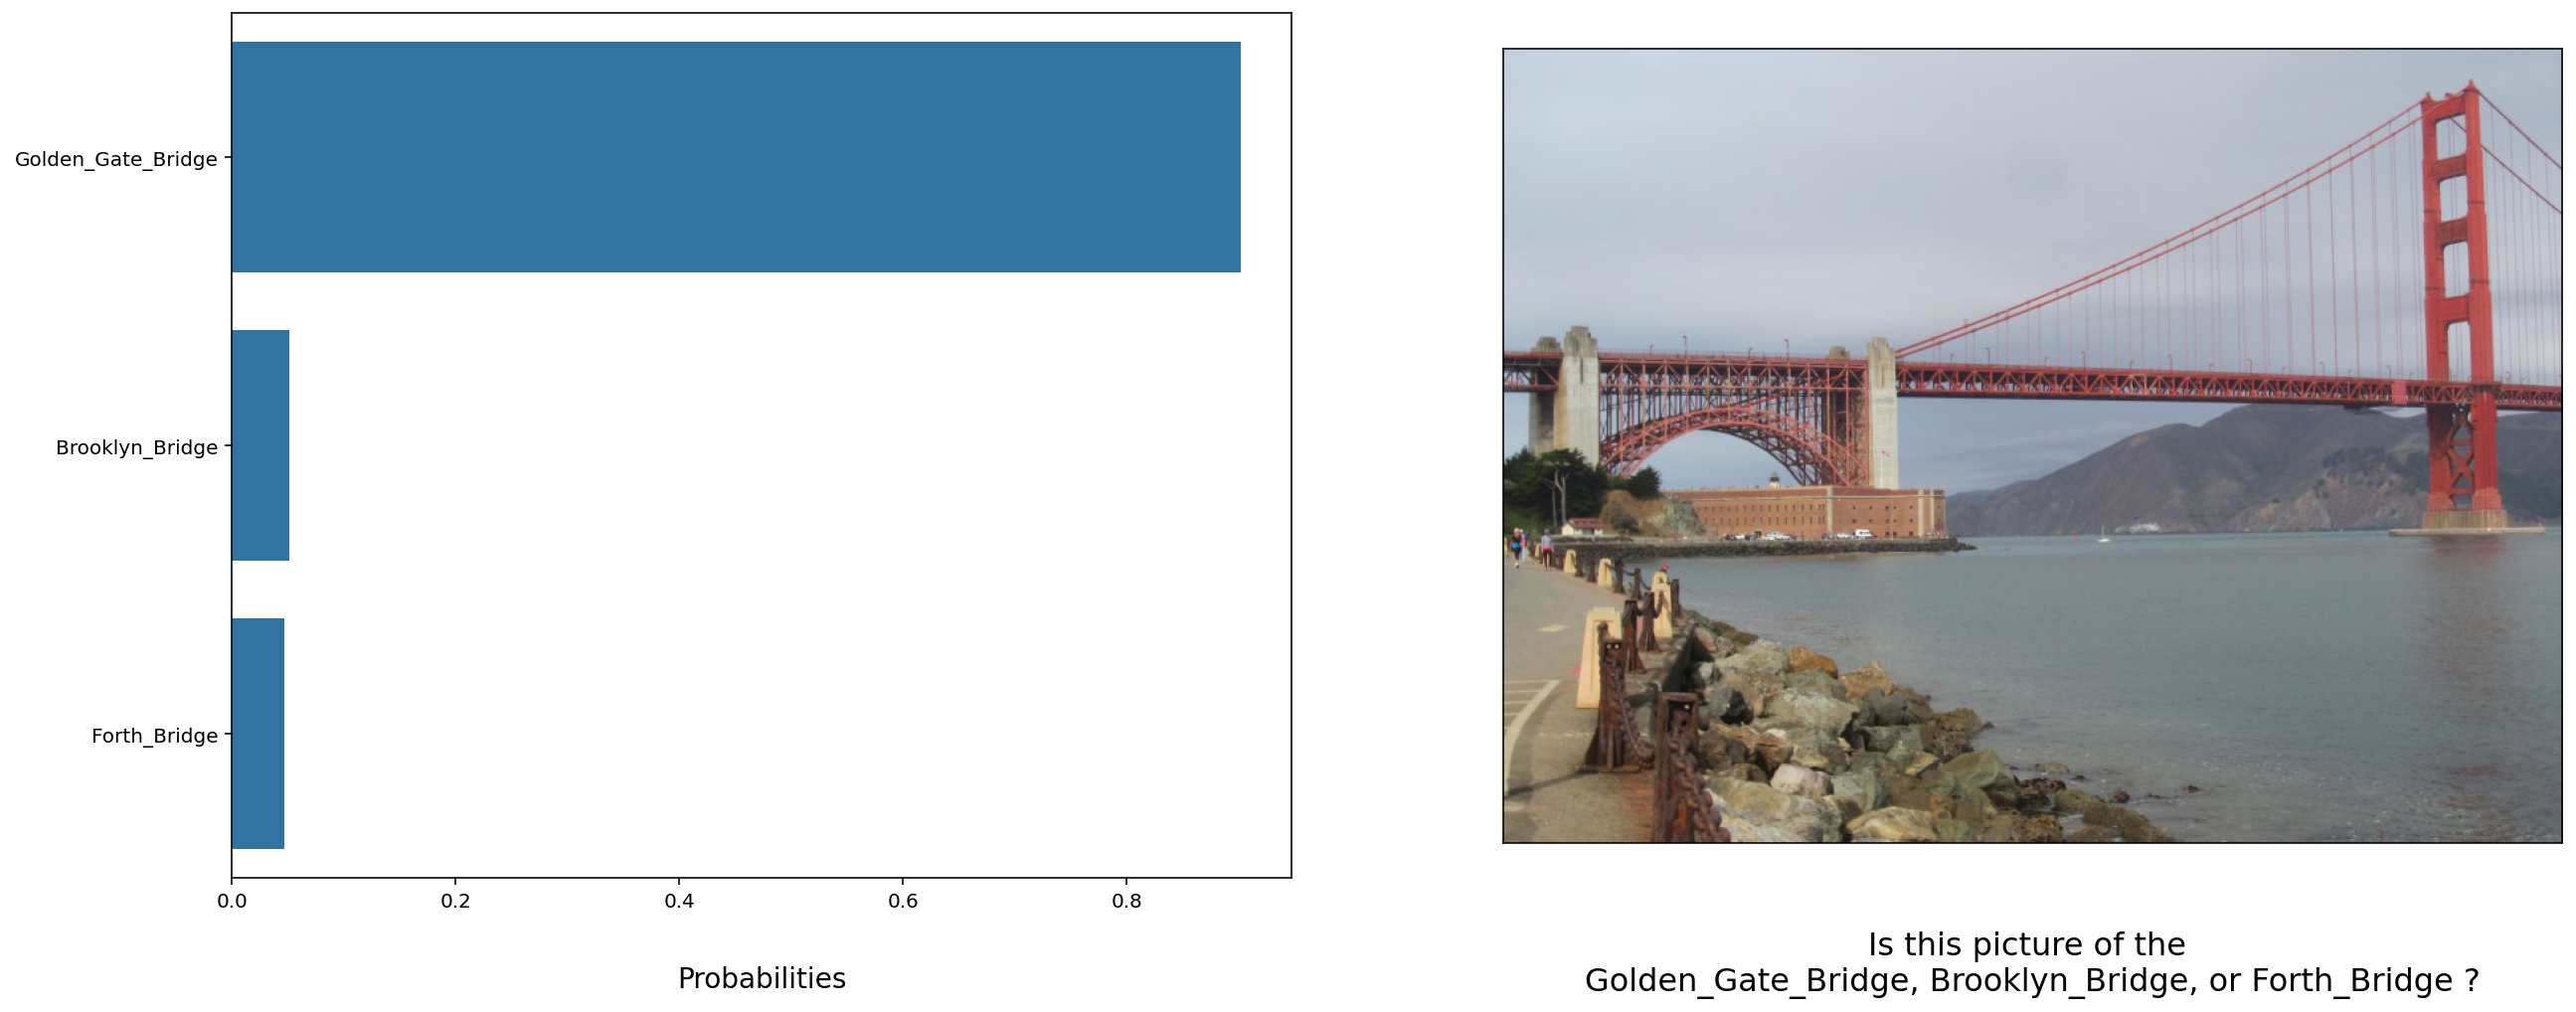

In [82]:
def suggest_locations(img_path, count = 0):
    # get landmark predictions
    confidence, predicted_landmarks = predict_landmarks(img_path, 3)
    
    # Change confidence scores to probabilities
    confidence = confidence[0].detach().numpy()
    confidence = np.exp(confidence)/np.exp(confidence).sum()
    
    ##  display image and display landmark predictions
    image= np.array(Image.open(img_path).convert("RGB"))

    plt.figure(figsize=(21, 8))
    
    ax = plt.subplot(1, 2, 1)
   
    sns.barplot(x = confidence, y=predicted_landmarks,  color=sns.color_palette()[0])
    ax.set_title("Probabilities", y =-0.14, fontsize = 14)
    
    ax = plt.subplot(1, 2, 2)
    ax.imshow(image)
    ax.set_title(f"Is this picture of the \n{predicted_landmarks[0]}, {predicted_landmarks[1]}, or {predicted_landmarks[2]} ?", y= -0.20,
                fontsize = 16)
    ax.set_xticks([])
    ax.set_yticks([])

    
    plt.savefig(f"images/result{count}.png", facecolor = "white")
    
    plt.show()


# test on a sample image
suggest_locations('images/test/09.Golden_Gate_Bridge/190f3bae17c32c37.jpg')

### Test Our Algorithm

Running the `suggest_locations` function on images on my computer.


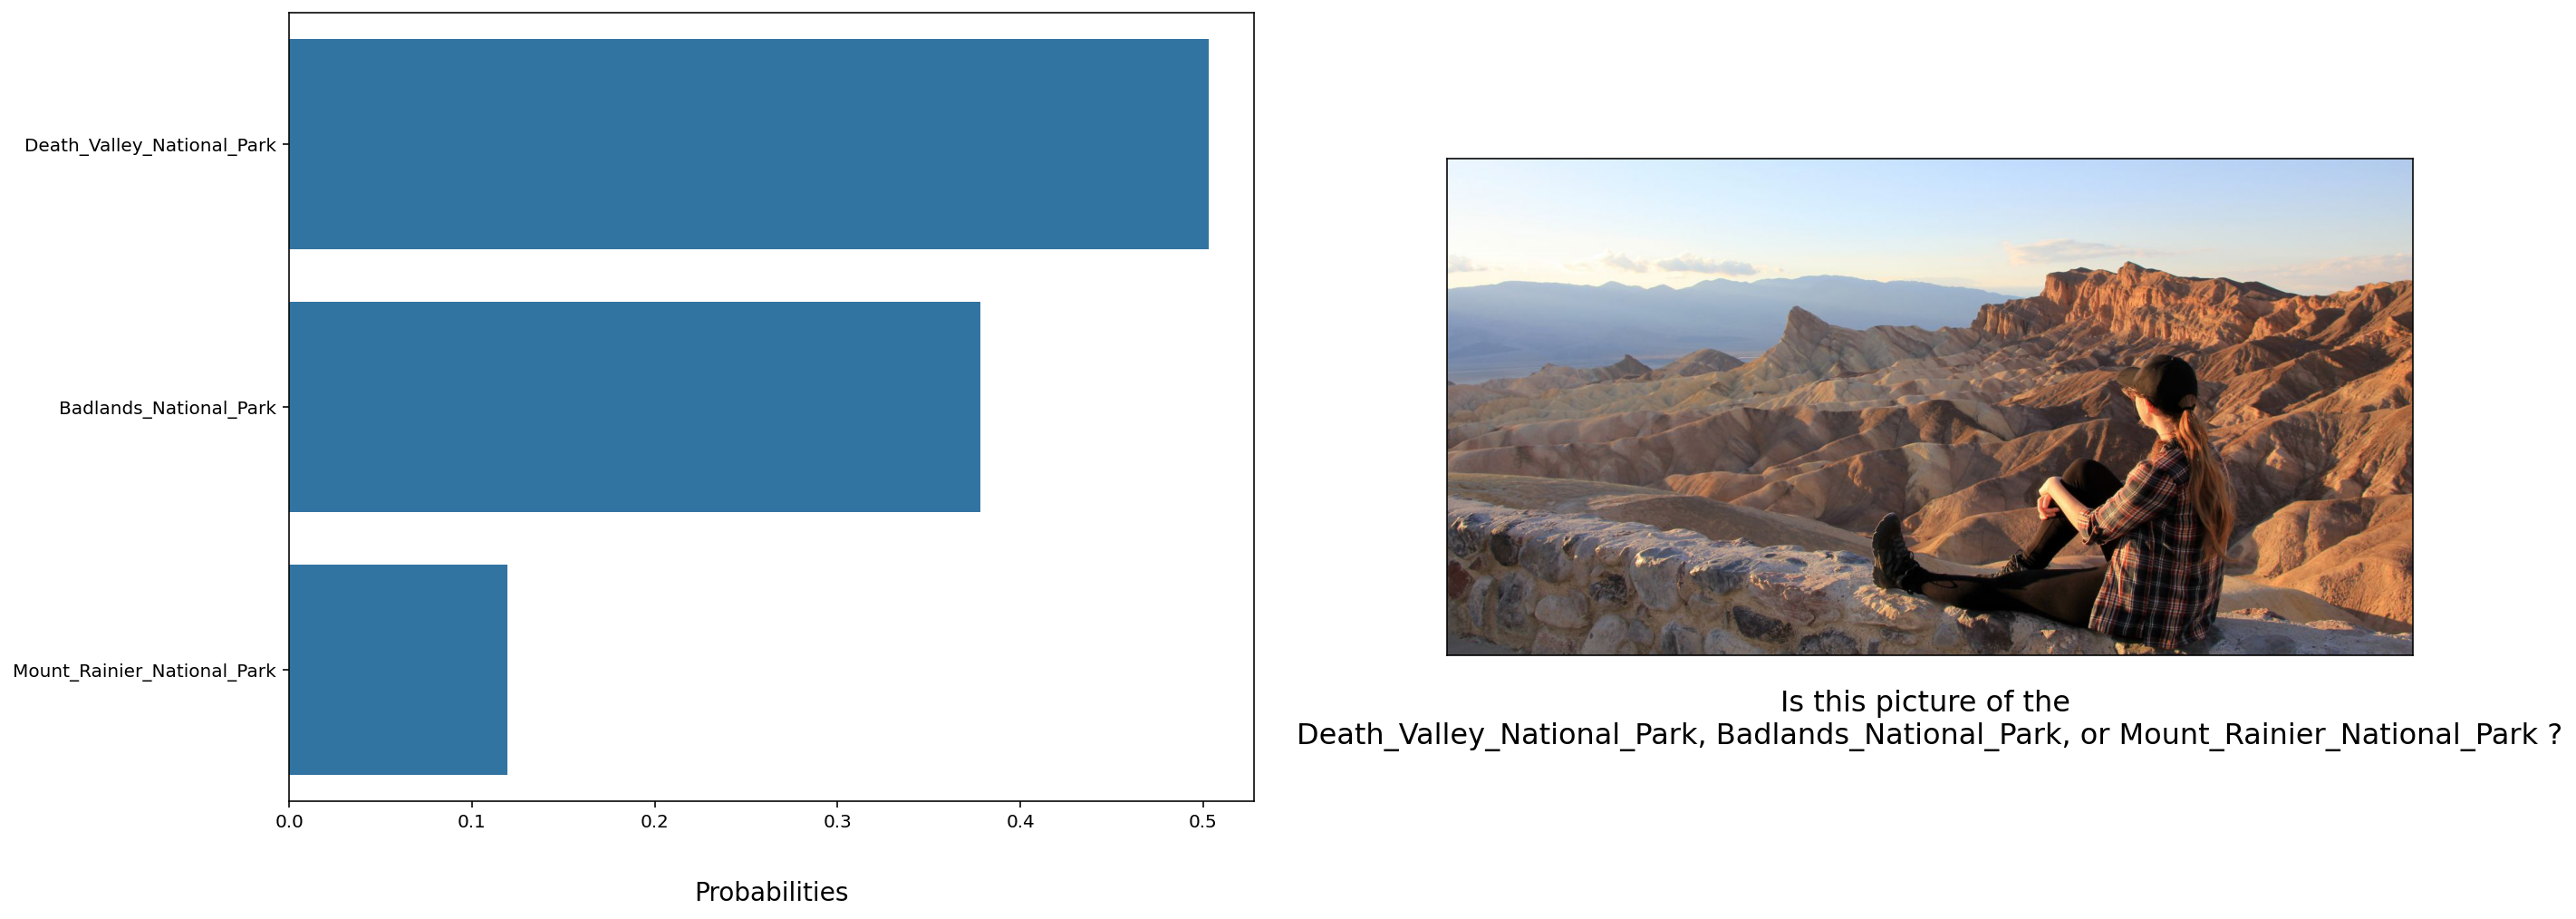

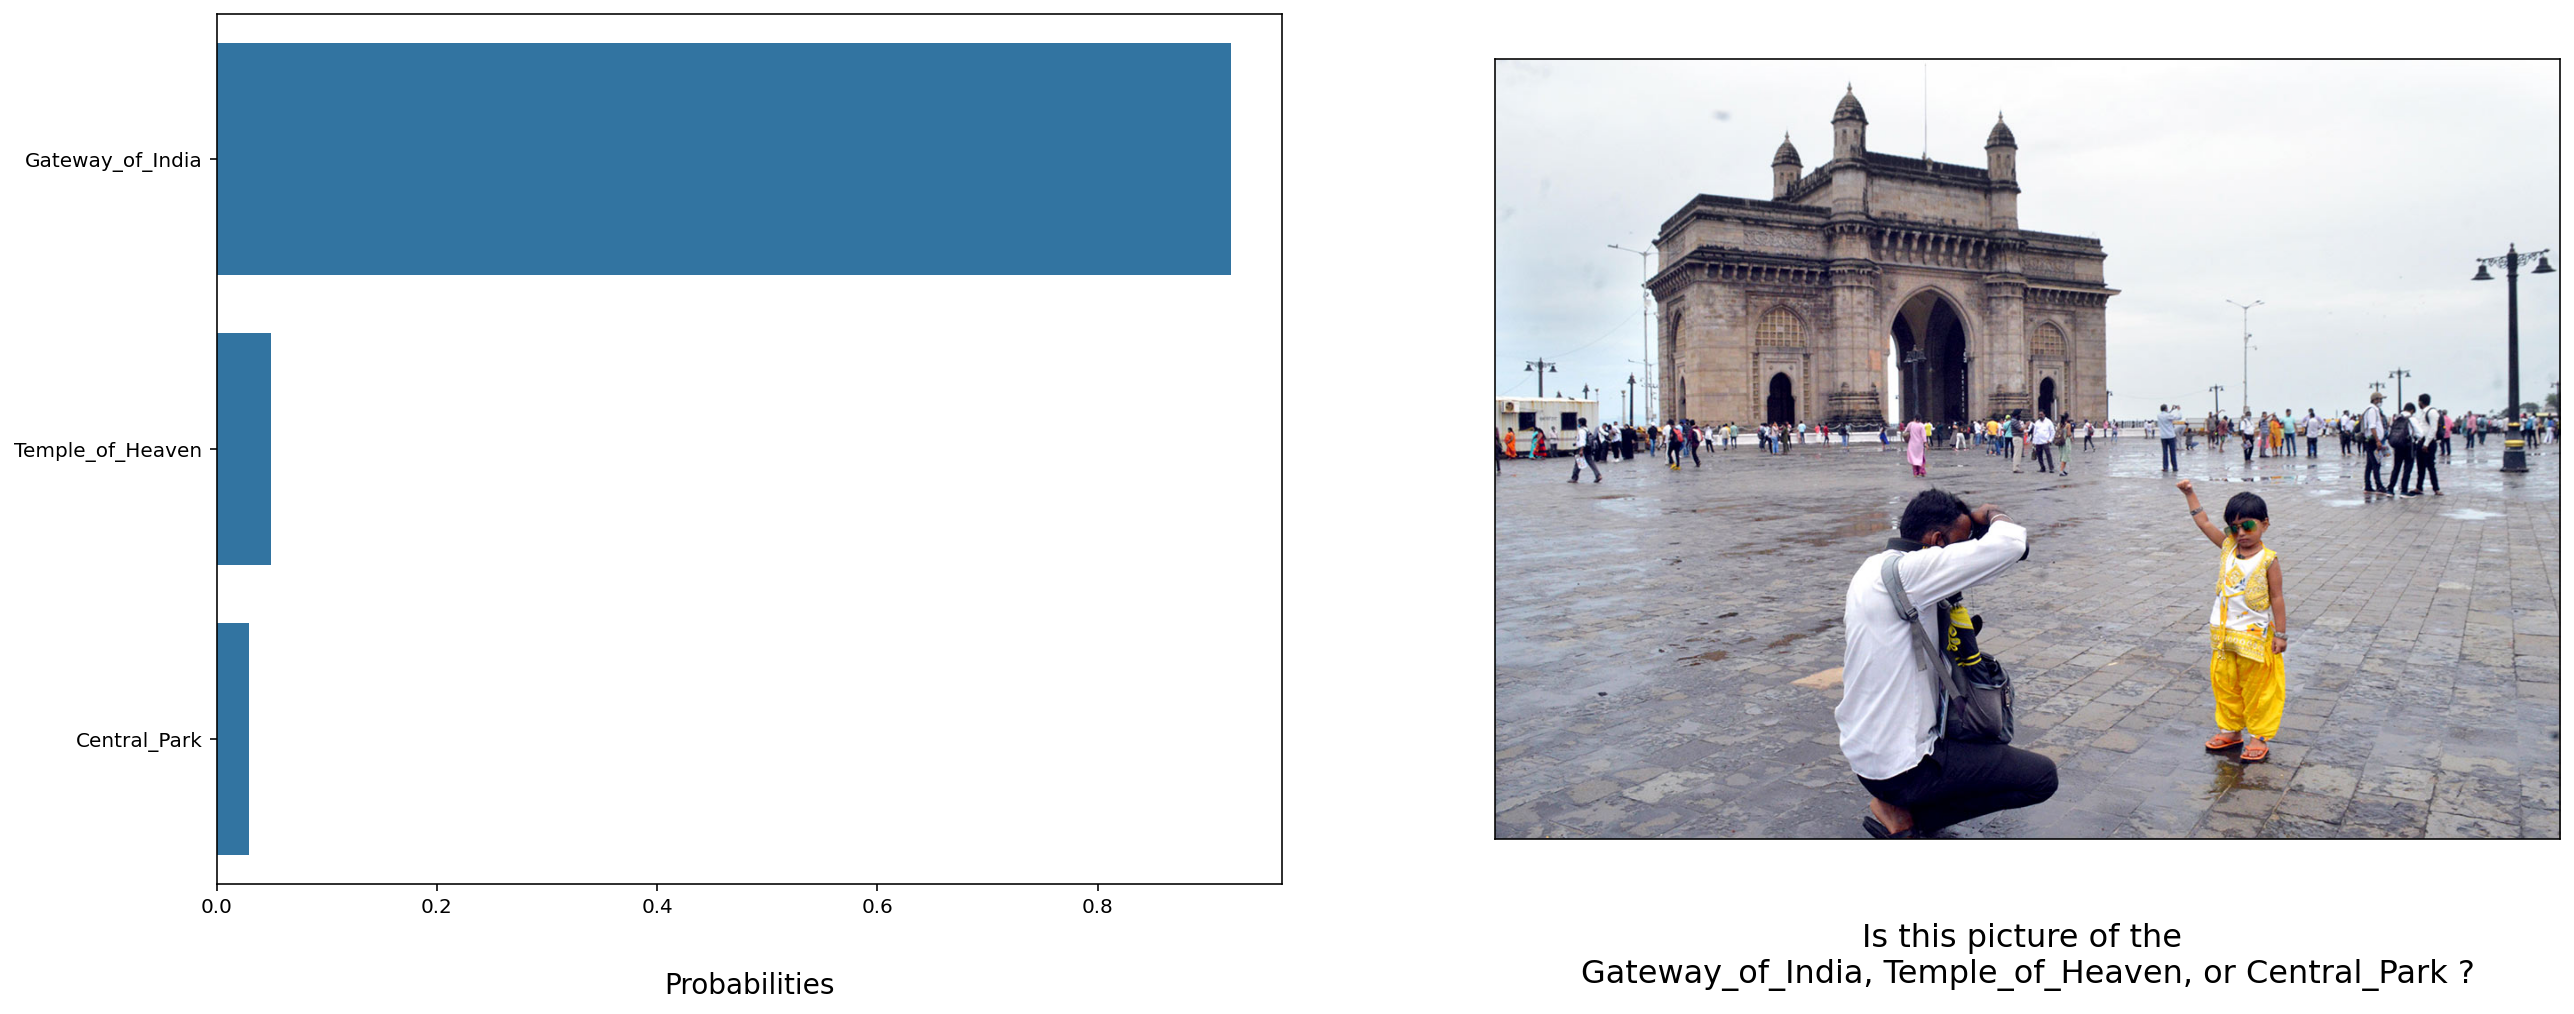

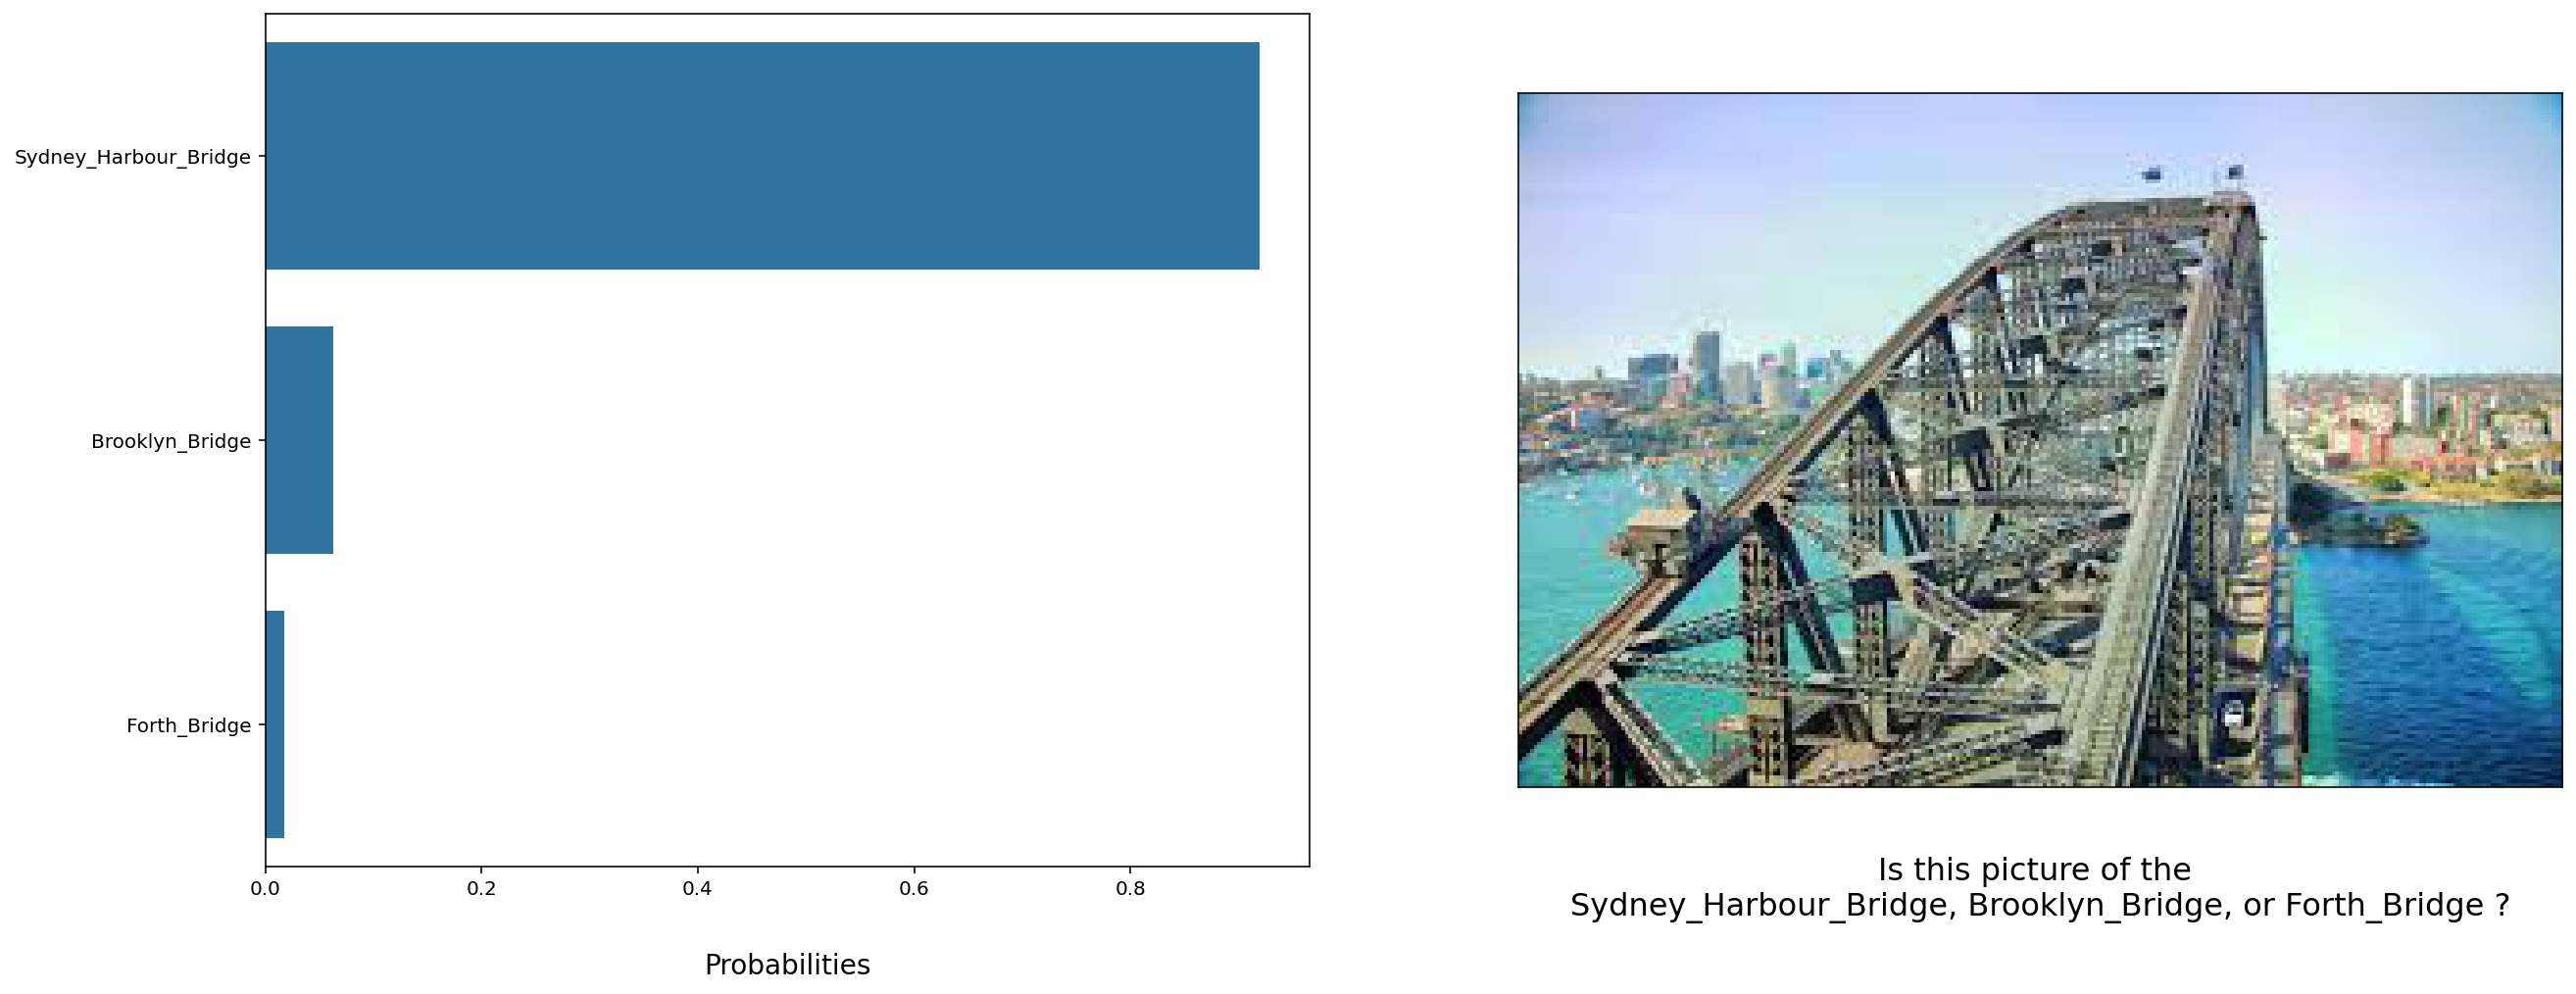

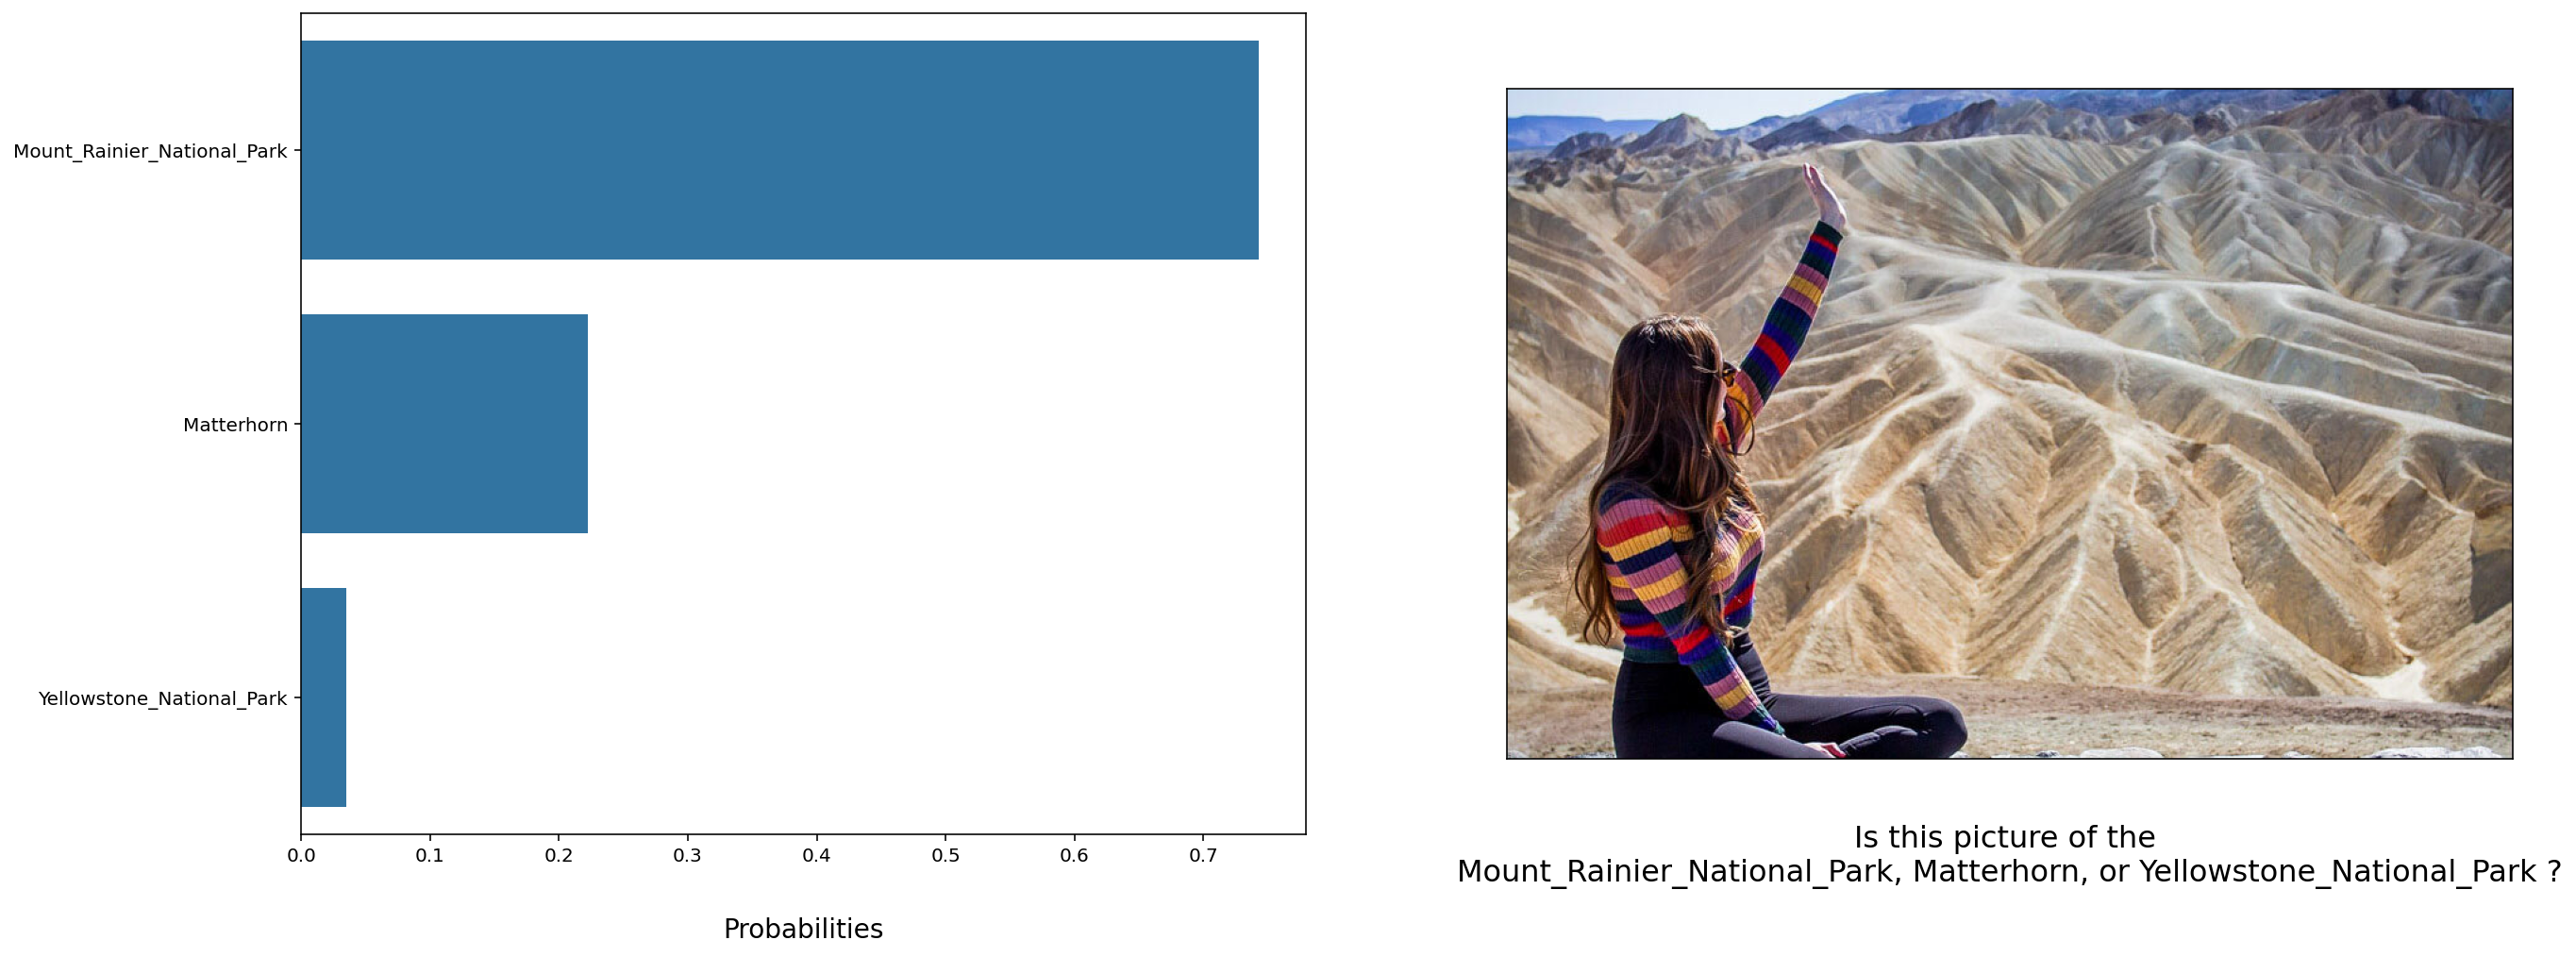

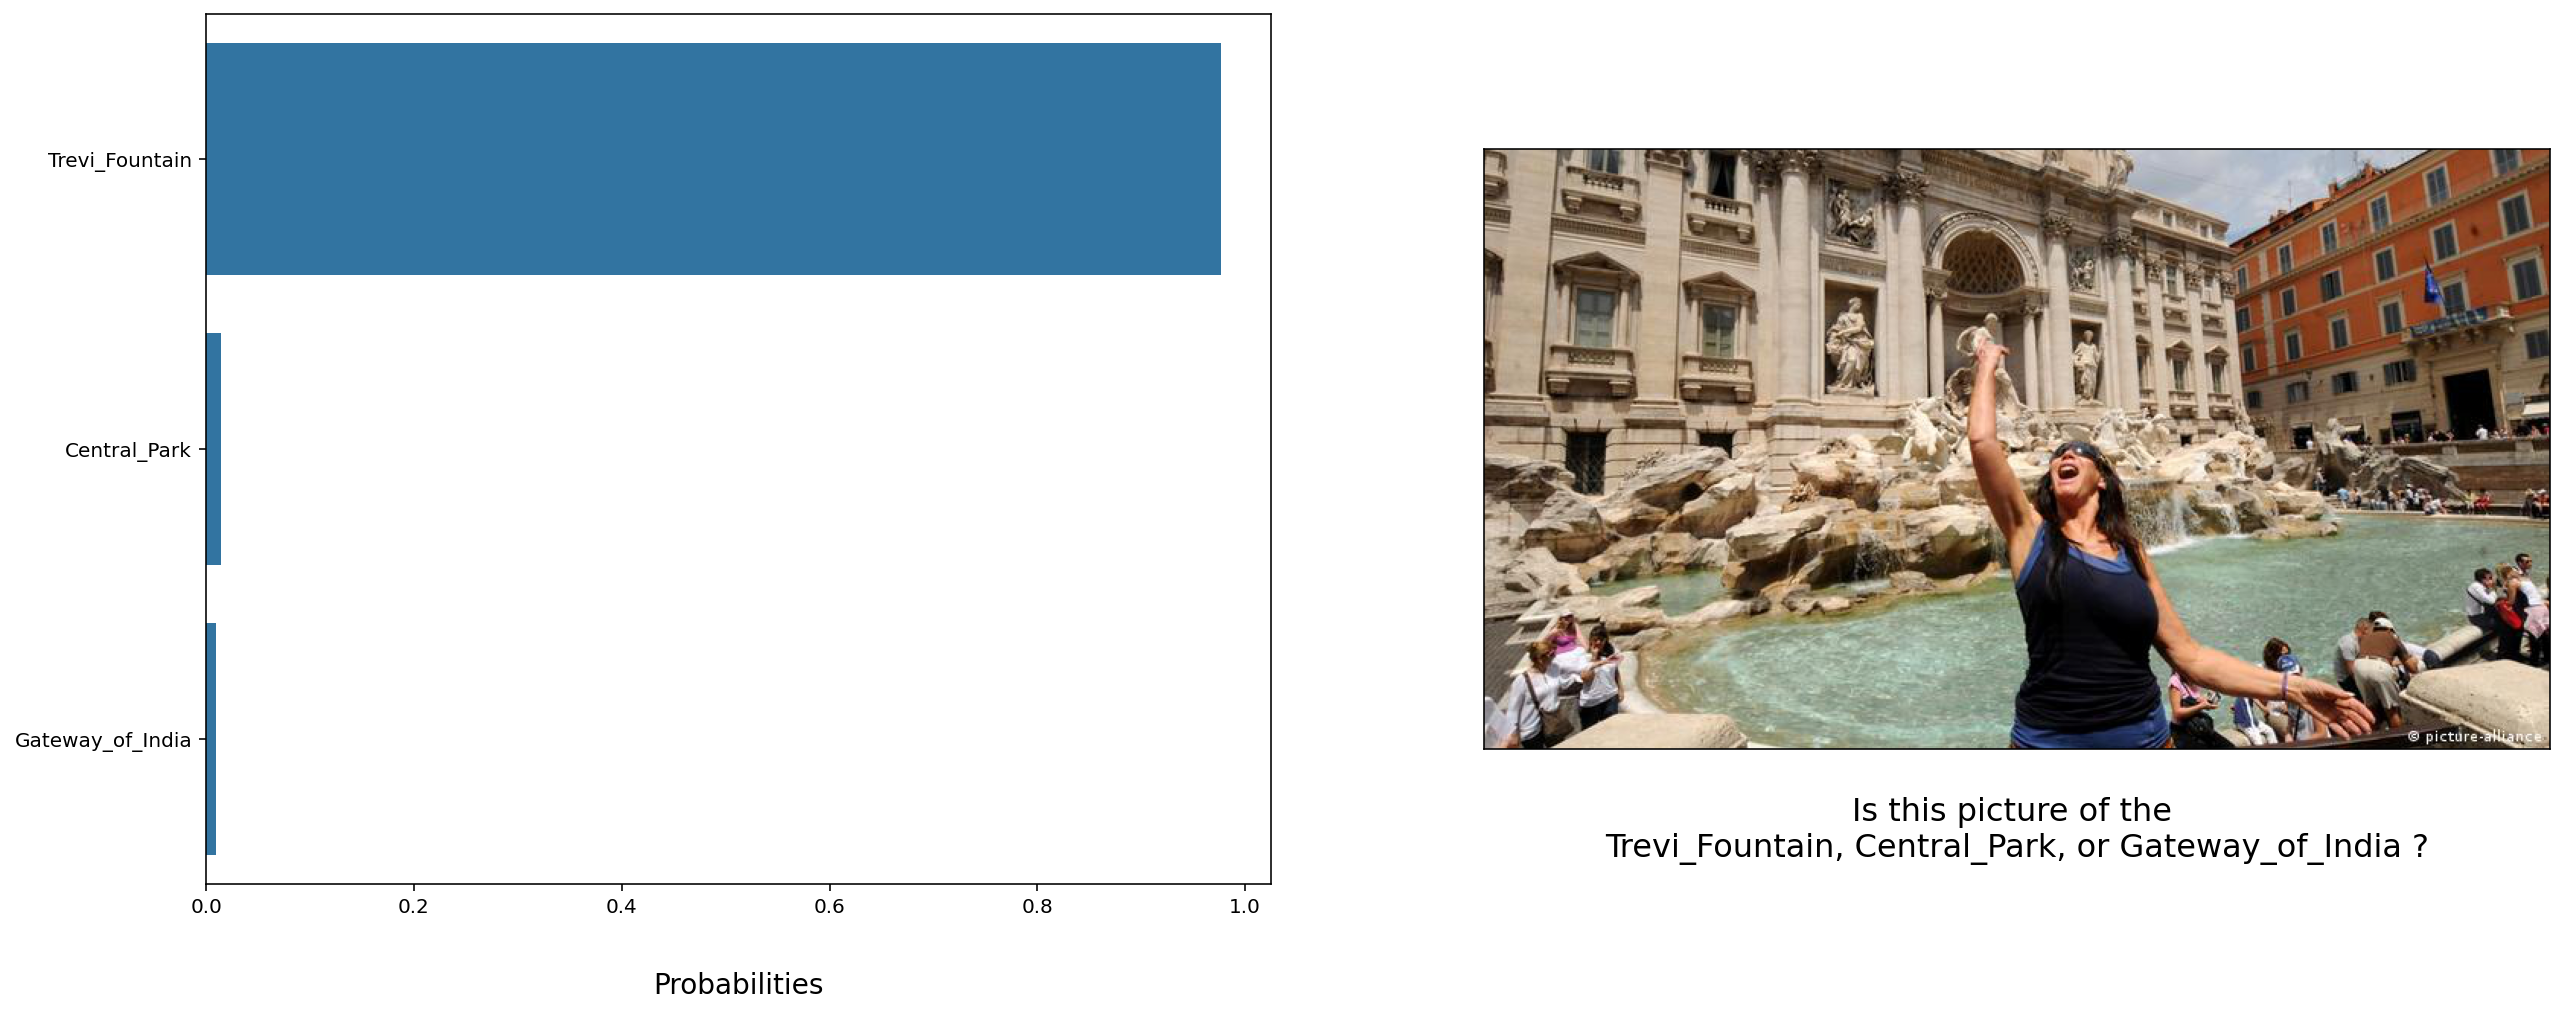

In [83]:
import os

img_paths=os.listdir(r"user_images")
    

for i,path in enumerate(img_paths):
    if path.find("checkpoints")==-1:
        suggest_locations(f"user_images/{path}", i)

__Description:__ 

It was better than I expected because I thought the model acted very weird during the training based on the validation loss. I think these are the possible improvements:
1. Maybe the architecture was too complex, and something like vgg16 would work better.
2. I could use `Adam` instead of `SGD` or a different learning rate. Maybe the oscillation in loss is because of my high initial learning rate, though I had the lr-scheduler.
3. I realized that model gets confused by national parks. So maybe more data on national parks will help.
4. I think I could augment data more 
5. Trying initial custom weights for the final layer in the transferred model since I realized it gave me better results in the scratch model.